# Parcels trajectory code

This notebook should provide a way to run the parcels code using local forcing fields.  The program will access data from the APDRC ERDDAP server, creat local netcdf files, read forcing from these files, then run trajectories in a forward mode.

- JimP June 2022

- Updated June 13 to run on google colab

## 1. Read/write to google drive

To run on google colab we first need to mount the directory on google drive.  This will be used to read forcing files and also to write output and save the plots.  The block below is standard.  Later, to access, we use "/content/drive/MyDrive/REU_2022".  I've added sub folders for forcing, output and plots.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Install "missing" packages

Some additional packages are needed since they don't come with google colab; load these here using pip (need the leading !)

In [ ]:
!pip install basemap
!pip install parcels
!pip install cgen
!pip install pymbolic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 863 kB 4.5 MB/s 
     |████████████████████████████████| 6.3 MB 32.7 MB/s 
     |████████████████████████████████| 30.5 MB 53.6 MB/s 
     |████████████████████████████████| 219 kB 43.6 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=edc33fcf521d1bed4599c72b5e4eed67b1ca444f5e2db6e04c940fa6667206b5
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.2 MB/s 
  Created wheel for parcels: filename=parcels-2.0.0-py3-none-any.whl size=1443240 sha256=65b919c19020f6232ecc2b361dc8b50ebcadb8ea7cde52a197474b40399527e3
  Stored in directory: /root/.cache/pip/wheels/0a/24/2b/a319803019867c4186d9f91f4c71d094aefc5c1cec303f6cb9
Successfully built parcels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70 kB 3.1 MB/s 
  Created wheel for cgen: filename=cgen-2020.1-py3-none-any.whl size=15836 sha256=aaa29a6ce27a707410693244d8d33cd67390073c8a3aa5304dab4acf1fa9186d
  Stored in directory: /root/.cache/pip/wheels/2a/ea/03/babc69df7b9bbdd77352d860912ae9a246b538f3fef47792c5
  Created wheel for pytools: filename=pytools-2022.1.12-py2.py3-none-any.whl size=65034 sha256=6fe2a2169ce7249c3a119fa7835020c470a6920a0bfdc7d6244f

## 3. Import all packages

In [ ]:
# load all necessary packages
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode
import numpy as np
import pandas as pd
import math
from datetime import timedelta
from operator import attrgetter
import pymbolic
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, num2date

## 4. Set run parameters
The variables "model" and "depth" will be used as the file name for the forcing and output.  A forward run will release particles along a line specified by lat1/lat2 and lon1/lon2 with "npart" number of points

There are three basic steps that can be enabled:
1. read forcing from server (read_data = True) or from local disk (read_data = False)
2. run parcels model (run_parcels = True)
3. make plots (make_plots = True)
4. release multiple trajectories from same point (repeat = True)
For example, to simply make plots from older runs, set run_parcels to False and make_plots to True

### 4A. Note on forcing fields
The forcing fields used come from two different global, operational models: the European Center for Medium Range Forecasts (ECMWF) Ocean Reanalysis (ORA-S5) and the NOAA Global Ocean Data Assimliation System (GODAS).  We get the output from the APDRC ERDDAP server as follows:
* Monthly mean GODAS zonal (east-west) current: http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_fbd0_32c1_b107.html
*  Monthly mean GODAS meridional (north-south) current: http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_3720_6ac2_d507.html
* Monthly mean ORA-S5 zonal (east-west) current: http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_9faa_add2_cf6f.html
* Monthly mean ORA-S5 meridional (north-south) current: http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_5e69_05b4_223f.html

The process for creating and saving a local version:
1. go to specific URL above
2. select the time range
3. select the lat range: 0 to 60N
4. select the lon range: 120 to 280
5. click output as netcdf (.nc), OR,
5. click on "generate the URL"
6. copy/paste the resulting URL in the notebook (below is an example)

http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_fbd0_32c1_b107.htmlTable?uogrddsl[(2001-01-01T00:00:00Z):1:(2015-12-31)][(105):1:(105)][(0):1:(60)][(120):1:(280)]

http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_3720_6ac2_d507.htmlTable?vogrddsl[(2001-01-01T00:00:00Z):1:(2015-12-31)][(105):1:(105)][(0):1:(60)][(120):1:(280)]

http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_9faa_add2_cf6f.htmlTable?vozocrte[(2001-01-01):1:(2015-12-31)][(108.0303):1:(108.0303)][(0):1:(60)][(120):1:(280)]

http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_5e69_05b4_223f.htmlTable?vomecrtn[(2001-01-01):1:(2015-12-31)][(108.0303):1:(108.0303)][(0):1:(60)][(120):1:(280)]


In [ ]:
read_data = False
run_parcels = True
make_plots = True
repeat = False
forward=True

The model start time is specified by year and month, and model can be ORA or GODAS

In [ ]:
year = '2022'
month1 = '01'
month2 = '12'
model = 'ORA'
vdepth = 5.140361 #1045.854 #508.6399 108.0303 1945.296 47.21189 1516.364 5.140361 26.5583 13.99104
#model = 'GODAS'
#vdepth =  949  #459.0 105.0 949 2174 55 1479 5 25 15
depth = str(int(vdepth))

Set length of run in days

In [ ]:
yrsruntime= 25.0
lengthofrun= str(int(yrsruntime)) # in years
ndays = 365.0 * yrsruntime

Set number of repeat trajectories.  For example, if this is set to 24 hours, a trajectory will be released at this point once per day

In [ ]:
repeat_hour = 30.0 * 24.0
nstart = 1
if repeat == False:
    repeat_hour = 0

Setup parameters 
* specify the number of starting points (npart), starting lat and lon (lat1,lon1,lat2,lon2), OR
* provide list of lats/lons for starting points

In [ ]:
if forward:
  experiment = 'forward_' + model + '-' + year + '_' + depth + '_' + lengthofrun + '_years_' + 'box'
else:
  experiment = 'backward_' + model + '-' + year + '_' + depth + '_' + lengthofrun + '_years_' + 'box'

'''
# for line
npart = 10
lat1 = 30.0
lat2 = 30.0
lon1 = 210.0
lon2 = 220.0
'''
# start lat and lon of garbage patch particles

start_lat = [31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 
             32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 
             33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 
             34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 
             35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 
             36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 
             37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 
             38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 
             39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 
             40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0]

start_lon = [211, 212, 213,214,215,216,217,218,219,220,
             211, 212, 213,214,215,216,217,218,219,220,
             211, 212, 213,214,215,216,217,218,219,220,
             211, 212, 213,214,215,216,217,218,219,220,
             211, 212, 213,214,215,216,217,218,219,220,
             211, 212, 213,214,215,216,217,218,219,220,
             211, 212, 213,214,215,216,217,218,219,220,
             211, 212, 213,214,215,216,217,218,219,220,
             211, 212, 213,214,215,216,217,218,219,220,
             211, 212, 213,214,215,216,217,218,219,220]

'''
# start lat and lon of Mexico particles

start_lat=[22,
           21,
           20,
           19,
           17,
           15,
           15,
           14,
           15,
           13,
           12,
           10,
           8,
           7,
           7,
           7]
start_lon=[250,252,254,256,258,260,262,264,266,268,270,272,274,276,278,280]


# start lat and lon of Japan particles
start_lat=[30,
           31,
           31,
           32,
           33,
           32, 
           32,
           32,
           32,
           32,
           33,
           34,
           36,
           38, 
           40,
           40]

start_lon=[130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 140.2, 140,4, 140.6, 143.8]


# start lat and lon of Philippines particles
start_lat=
'''

print('Number of latitudes', len(start_lat))
print('Number of longitudes',len(start_lon))

npart=int(len(start_lat))


Number of latitudes 100
Number of longitudes 100


In [ ]:
print('Running experiment ', experiment)

Running experiment  forward_ORA-2022_5_25_years_box


### This should be the end of the user-defined parameters....

## 5. Get forcing files

If the variable "read_data" is true, then we go out to the server to get the data at run time.  Otherwise, this step is skipped and we read directly from disk (google drive).

In [ ]:
if read_data:
    import urllib
    time1 = year + '-' + month + '-' + day1
    time2 = year + '-' + month + '-' + day2
    constraint = '[(' + time1 + '):1:(' + time2 + ')][(vdepth):1:(vdepth)][(0):1:(60)][(120):1:(280)]'
    if model == 'ORA':
        root_url = 'http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_'
        URL_U = root_url + '9faa_add2_cf6f.htmlTable?vozocrte' + constraint
        URL_V = root_url + '5e69_05b4_223f.htmlTable?vomecrtn' + constraint
    elif model == 'GODAS':
        root_url = 'http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_'
        URL_U = root_url + 'fbd0_32c1_b107.htmlTable?uogrddsl' + constraint
        URL_V = root_url + '3720_6ac2_d507.htmlTable?vogrddsl' + constraint
    
    urllib.request.urlretrieve(URL_U, '/content/drive/MyDrive/REU_2022_copy/forcing_copy/' + model + '-' + year + '_' + depth + '_U_forcing.nc')
    urllib.request.urlretrieve(URL_V, '/content/drive/MyDrive/REU_2022_copy/forcing_copy/' + model + '-' + year + '_' + depth + '_V_forcing.nc')

In [ ]:
# specify the filenames for the U,V fields
filenames = {'U': '/content/drive/MyDrive/REU_2022_copy/forcing_copy/' + model + '-' + year + '_' + depth + '_U_forcing.nc',
             'V': '/content/drive/MyDrive/REU_2022_copy/forcing_copy/' + model + '-' + year + '_' + depth + '_V_forcing.nc'}

In [ ]:
# set the variable names; here the first part is what parcels is expecting, the second is from the file
#   'U' is the zonal velocity, given in our file by 'vozocrte'
#   'V' is the meridional velocity, given in our file by 'vomecrtn'
#   'lat' is the latitude, given in our file by 'latitude'
#   'lon' is the longitude, given in our file by 'longitude'
#   'time' is time, given in our file by 'time'
if model == 'ORA':
    variables = {'U': 'vozocrte',
                 'V': 'vomecrtn'}
if model == 'GODAS':
    variables = {'U': 'uogrddsl',
                 'V': 'vogrddsl'}

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

## 6. Initialize parcels run

In [ ]:
# Check start and end times
uvar = Dataset(filenames['U'])
vvar = Dataset(filenames['V'])
timevar = uvar.variables['time']
time_convert = np.array(num2date(timevar[:],timevar.units))
time_convert = time_convert.astype('datetime64[ns]')
udate1 = pd.to_datetime(time_convert)[0]
udate2 = pd.to_datetime(time_convert)[-1]
timevar = vvar.variables['time']
time_convert = np.array(num2date(timevar[:],timevar.units))
time_convert = time_convert.astype('datetime64[ns]')
vdate1 = pd.to_datetime(time_convert)[0]
vdate2 = pd.to_datetime(time_convert)[-1]
print('Forcing fields (u,v) start at', udate1, 'and', vdate1)
print('Forcing fields (u,v) end at', udate2, 'and', vdate2)

Forcing fields (u,v) start at 1979-01-15 00:00:00 and 1979-01-15 00:00:00
Forcing fields (u,v) end at 2018-12-15 00:00:00 and 2018-12-15 00:00:00


In [ ]:
# create fieldset and run forward
if run_parcels:
    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions,allow_time_extrapolation=True) # check to see if allow_time_extrapolation only refers to the last month or does it go through all 12 months after
    # time-step in forcing file in seconds
    dt_forcing = fieldset.U.grid.time[1] - fieldset.U.grid.time[0] # 2678400 seconds = 31 days = 1 month
    repeatdt = timedelta(hours=repeat_hour)
    
    # start_lon = np.linspace(lon1,lon2,npart) # use only if start_lat and start_lon are not giving specific points
    # start_lat = np.linspace(lat1,lat2,npart)
    if repeat:
       #from a line
       # pset = ParticleSet.from_line(fieldset=fieldset, pclass=JITParticle, size=npart,
       #                              start=(lon1,lat1), finish=(lon2,lat2), #time= yrsruntime*12*2678400, # runtime (years) in seconds
       #                              repeatdt=repeatdt)
        #group of points
        pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, 
                                     lon=start_lon, lat=start_lat, depth=None, #time= yrsruntime*12*2678400,
                                     repeatdt=repeatdt)

                                   
    else:
      # from a line
      #pset = ParticleSet.from_line(fieldset=fieldset, pclass=JITParticle, size=npart,
      #                            start=(lon1,lat1), finish=(lon2,lat2), # time= yrsruntime*12*2678400,
      #                            repeatdt=None)
      # group of points
      pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, 
                                     lon=start_lon, lat=start_lat, depth=None,
                                     repeatdt=None)
  

                                    


In [ ]:
months= 12*(yrsruntime)
ntime = months / ( dt_forcing / 86400.0 * months ) * ndays + 1
#ntime = 24.0 / ( dt_forcing / 86400.0 * 24 ) * ndays + 1 #what is the purpose of this?
ntraj = npart
if repeat:
    nstart = ( ndays * 24 / repeat_hour + 1 )
print('Run should have trajectories starting/ending at', int(ntraj), 'locations with', int(nstart), 
      'start times at each and', int(ntime), 'integration (path) times')
print('Arrays will be',int(ntraj*nstart),'by',int(ntime))

Run should have trajectories starting/ending at 100 locations with 1 start times at each and 295 integration (path) times
Arrays will be 100 by 295


## 7. Run code
__NOTE__: sometime you have to run this twice (?) on local machines; so far this is NOT The case on google colab

The output file contains the lat/lon of the particles over time (set here as traj_output).

This is taken from [tutorial_Agulhasparticles](https://github.com/OceanParcels/parcels/blob/master/parcels/examples/tutorial_Agulhasparticles.ipynb) in order to delete particles that go out of bounds. I don't know if there is another option that can be used to track the particles after they leave the perimeter because there is no data in the netCDF file that has velocities for those positions. 

In [ ]:
def DeleteParticle(particle,fieldset,time):
  particle.delete()

In [ ]:
# specify the output file that will contain the lat/lon points of the particles then integrate
# here we set the output time resolution to be the same as the forcing (e.g., tides at 1 hour
# and ROMS at 3 hours)

traj_output = '/content/drive/MyDrive/REU_2022_copy/output_copy/box_output_copy/' + experiment + '.nc'
if run_parcels:
  if forward:
    output_file = pset.ParticleFile(name=traj_output, outputdt=timedelta(hours=dt_forcing/3600.0)) #dt_forcing/3600=output every month
    pset.execute(AdvectionRK4, runtime=timedelta(days=ndays), 
                 dt=timedelta(hours=24), 
                 recovery={ErrorCode.ErrorOutOfBounds:DeleteParticle},
                 output_file=output_file)
# run backwards by making timedelta -timedelta and then make time=the last time in forcing field when we define the pset
  else:
    output_file = pset.ParticleFile(name=traj_output, outputdt=timedelta(hours=dt_forcing/3600.0)) #dt_forcing/3600=output every month
    pset.execute(AdvectionRK4, runtime=timedelta(days=ndays), 
                 dt=-(timedelta(hours=24)), 
                 recovery={ErrorCode.ErrorOutOfBounds:DeleteParticle},
                 output_file=output_file)



INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-0/6a1e0248a8d3cd95183d439bd993946e.so
100% (788400000.0 of 788400000.0) |######| Elapsed Time: 0:00:40 Time:  0:00:40


## 8. Plot results

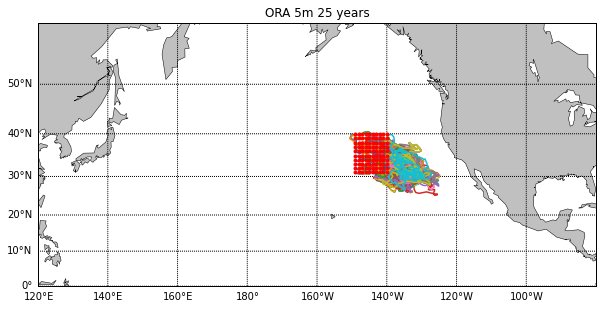

In [ ]:
# mo betta one
if make_plots:
    data = Dataset(traj_output)
    traj = data.variables['trajectory'][:][:]
    x = data.variables['lon'][:][:]
    y = data.variables['lat'][:][:]
    
    fig, ax = plt.subplots(figsize=(10,10))

    m = Basemap(projection='merc',llcrnrlon=120.0,llcrnrlat=0.0,urcrnrlon=280.0,urcrnrlat=60.0,
                    resolution='c',lat_1=0.0,lat_2=60.0,lat_0=30.0,lon_0=180.0)
    
    m.drawcoastlines(color='black', linewidth=0.5)
    m.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
    m.drawmapboundary()

    m.drawparallels(np.arange(0,60,10.0),labels=[1,0,0,0])
    m.drawmeridians(np.arange(120,280,20.0),labels=[0,0,0,1])
    plt.title(model + ' ' + depth + 'm ' + lengthofrun + ' years')
    
# plot trajectory with a red start (r*) and the start/end
# note the output (x,y) is dimensioned with trajectory number
# first, then time.  The trajectory number alternates between
# starting point and release time.  For example, x(0,0) is
# the initial time, starting point 1, first release; x(1,0) is
# initial time, starting point 2, first release; etc. then
# second release and so on.
    if repeat:
        for i in range(0,int(ntraj*nstart),int(ntraj)):
            for j in range(int(ntraj)):
                traj_color = 'C' + str(j)
                x2, y2 = m(x[i+j,:],y[i+j,:])
                plt.scatter(x2,y2,facecolors='none',edgecolors=traj_color)
        for i in range(ntraj):
            x1, y1 = m(x[i,0],y[i,0])
            plt.plot(x1,y1,'y*',markersize=16)
    else:
        for i in range(int(ntraj*nstart)):
            x2, y2 = m(x[i,:],y[i,:])
            plt.plot(x2,y2)
        for i in range(ntraj):
            x1, y1 = m(x[i,0],y[i,0])
            plt.plot(x1,y1,'r.') # color + symbol... so r* = red star... bs=blue square
    
    plt.savefig('/content/drive/MyDrive/REU_2022_copy/plots_copy/Box/since_1980/' + experiment + '.png', format = 'png')